<h6><center>Project Machine Learning</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Part 2 - Data Cleaning : Dimensionality Reduction </center>
<hr style=" border:none; height:3px;">
</h1>



We are going to test out these different approaches for dimensionality reduction :

+ Best/Forward/Backward selection and evaluation methods (adjusted training error, validation set, cross validation)
+ PCA (tunning of $M$ value, visualization and interpretation of the plots

## For google.colab

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup


In [2]:
!pip install statsmodels

In [3]:
!pip install chart_studio

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# numpy arrays are used to 
import numpy as np

# pandas is used to manipulate tabular data
import pandas as pd

# statsmodels provides classes and functions for the estimation of many different statistical models
import statsmodels.api as sm

# itertools implements a number of iterator building blocks for efficient looping
import itertools

# time provides various time-related functions
import time

# seaborn for correlation
import seaborn as sns

# Matplotlib is used to plot graphs
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Style options for plots
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## For PCA part
#################
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go

## Download Data 

We're going to download `data_airbnb` dataset. Our data has already been cleaned, scaled and split into train/validation/test sets. First of all, we are only using the training observations. In a second part, in order to test our data we will use only the validation set. We will also prepare the functions for the test set in order to be able to use it at the end.

Our objective is: 
+ to apply dimensionality reduction approaches 
+ to predict the `Price` of a night's accommodation on Airbnb in Berlin

In [7]:
# Load data train
data_train_df = pd.read_csv("/Users/albane/Desktop/ML/ml-project/data/data_train.csv")
data_train_df.head()
#data_train_df.describe()

# Load data validation
data_validation_df = pd.read_csv("/Users/albane/Desktop/ML/ml-project/data/data_val.csv")

# Load data test
data_test_df = pd.read_csv("/Users/albane/Desktop/ML/ml-project/data/data_test.csv")

Text(0.5, 1.0, 'Correlation between different features')

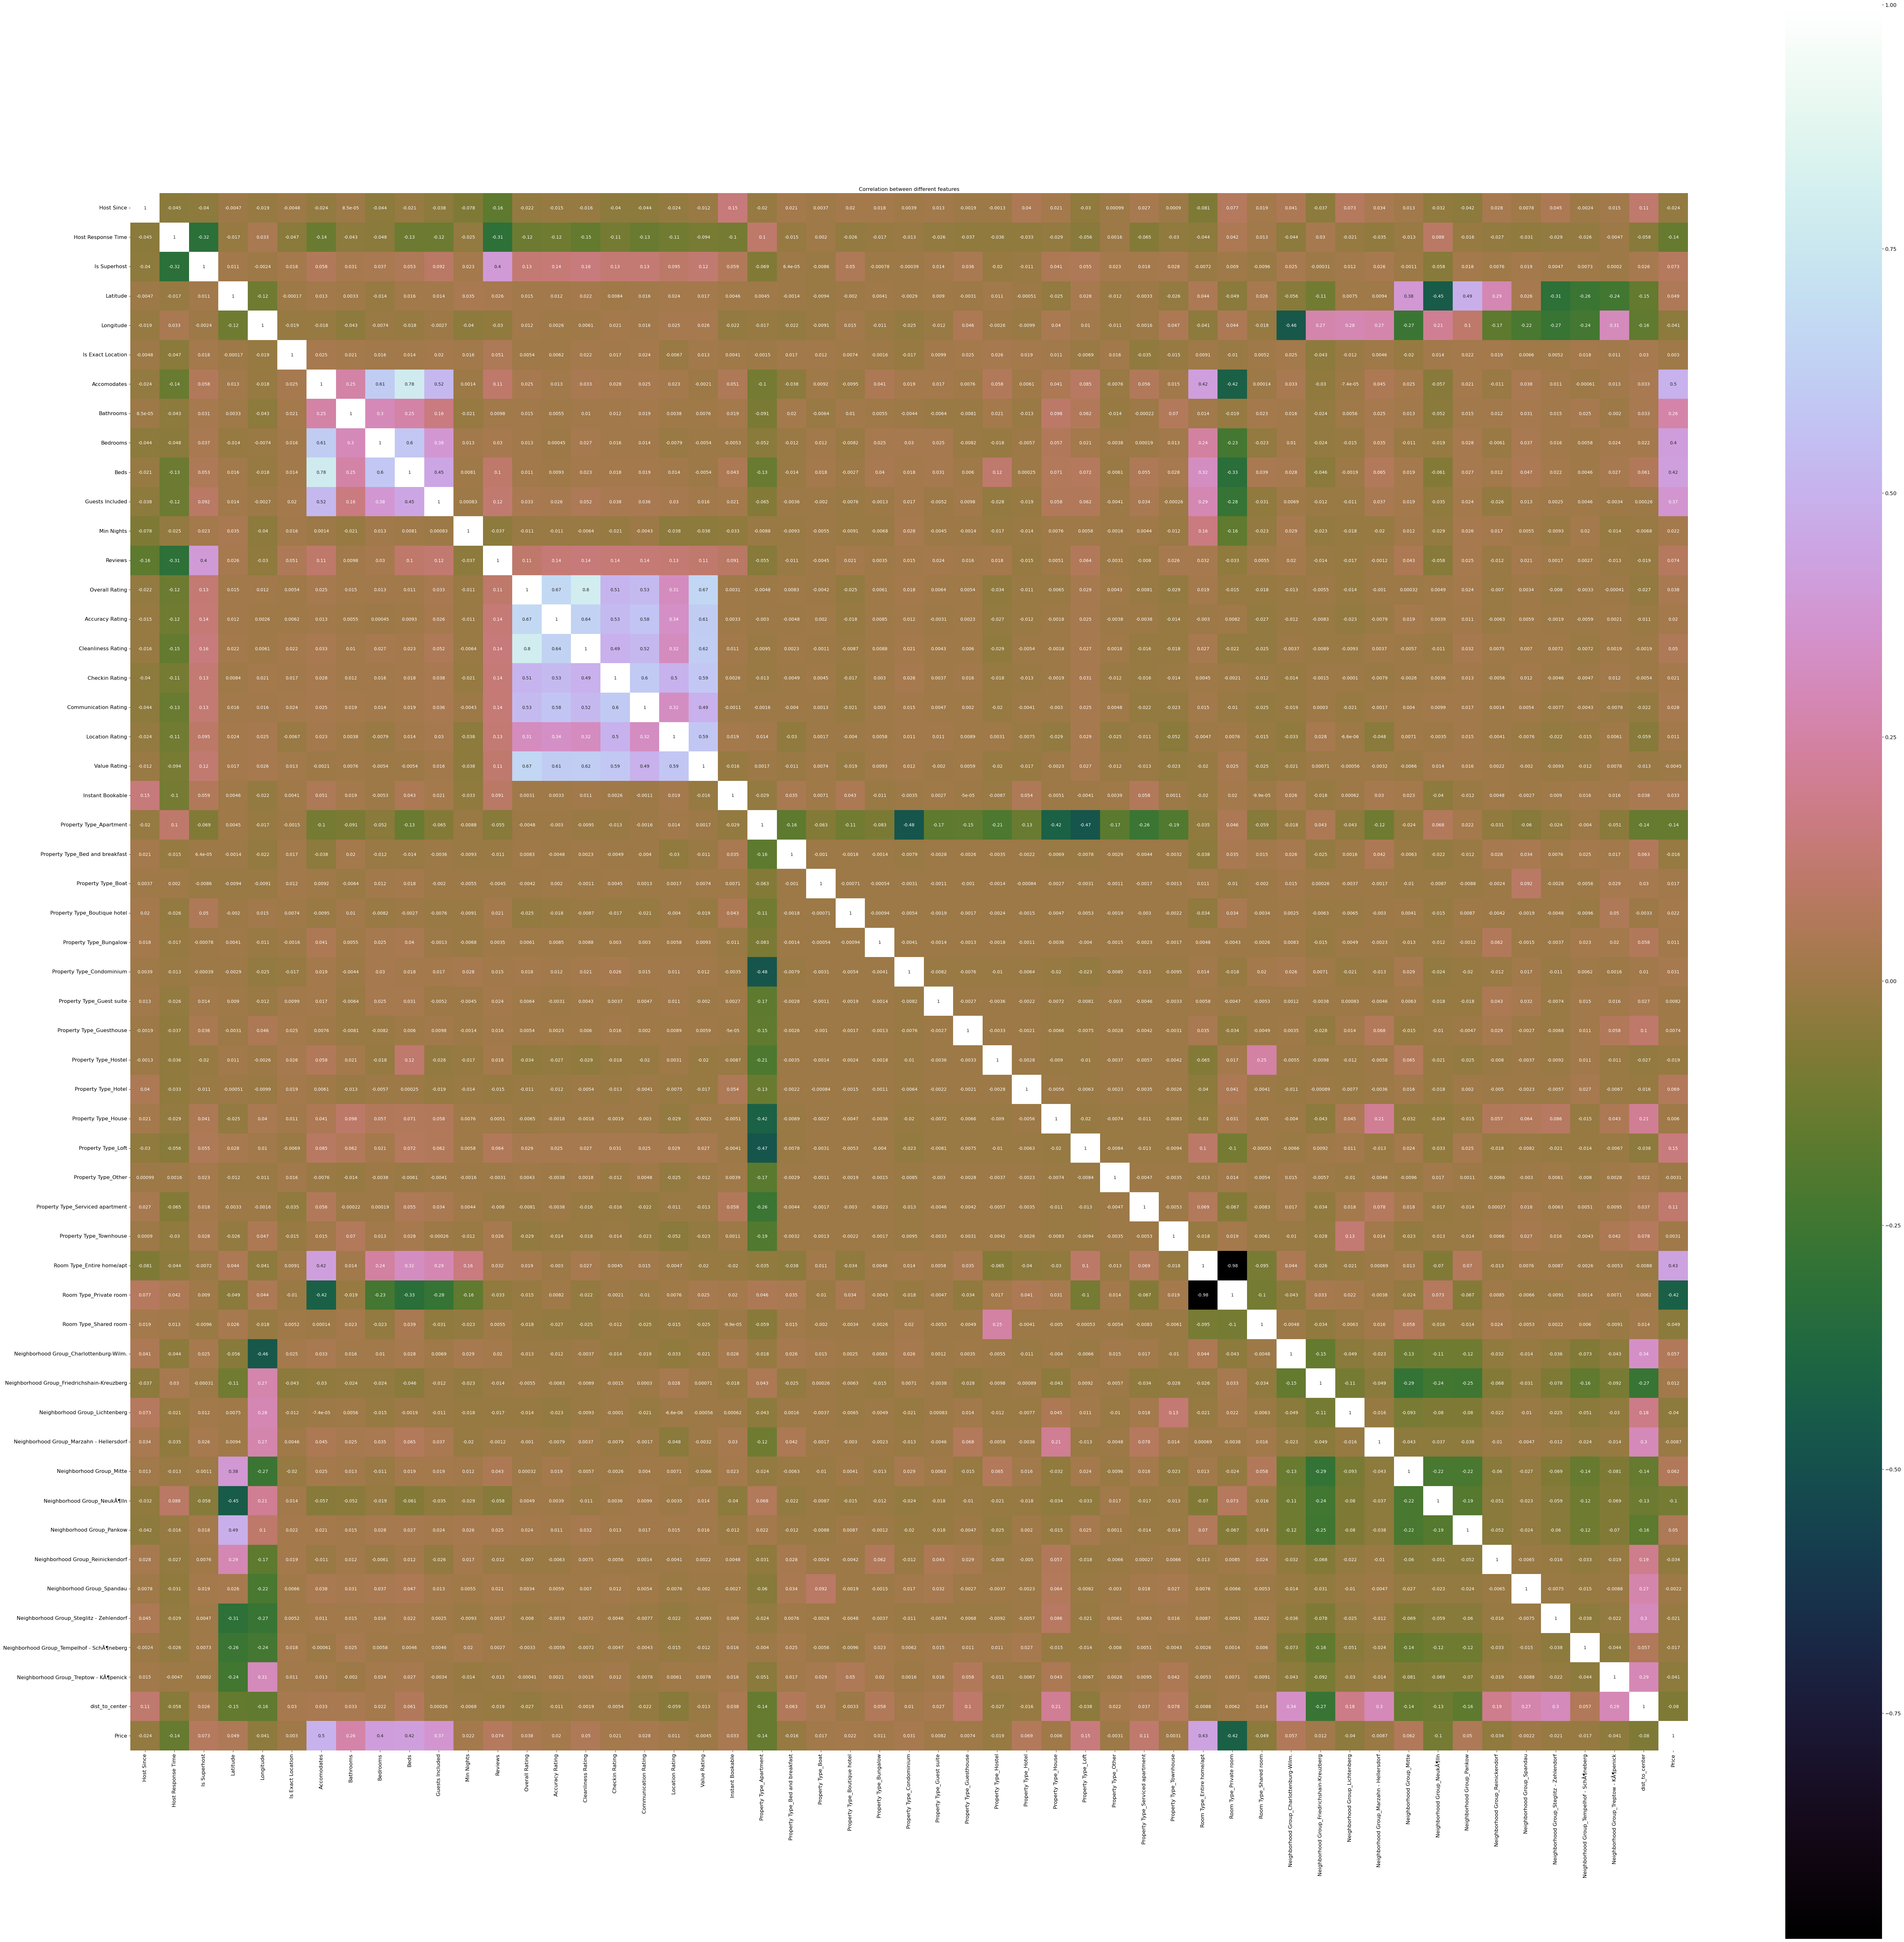

In [8]:
correlation = data_train_df.corr()
plt.figure(figsize=(80,80))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different features')

# Subset Selection Approaches


## Best Subset Selection

Our dataset has already been cleaned, scaled and split in the first part $Data$ $Cleaning$. We are only using the training observations.

In [9]:
# Extract the target variable
y_train = data_train_df.Price

# Drop the column with the target variable ('Price')
X_train = data_train_df.drop(['Price'], axis=1)

# Define the feature set X_train, our matrix data
X_train.shape

(9772, 52)

Using RSS, we will determine the best model:

In [10]:
def processSubset(feature_set):
    # Fit OLS (Ordinary Least Squares) model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_train[list(feature_set)]) - y_train) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [11]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X_train.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

The function returns a Dataframe with the best model.

We then call the function for each number of features $k$ (to save time, we only generated results up to the best 3-feature model) : 

In [12]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,4):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 52 models on 1 predictors in 0.16431212425231934 seconds.
Processed 1326 models on 2 predictors in 3.527393102645874 seconds.
Processed 22100 models on 3 predictors in 74.00542211532593 seconds.
Total elapsed time: 79.22365307807922 seconds.


We get a Dataframe with the best models we have generated and their RSS :

In [15]:
models_best

,RSS,model
1,18990140.021231,<statsmodels.regression.linear_model.Regressio...
2,15488064.836897,<statsmodels.regression.linear_model.Regressio...
3,14072918.127919,<statsmodels.regression.linear_model.Regressio...


With the `summary()` function we can access the details of a single model:

In [16]:
print(models_best.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.750
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                              9762.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:08:12   Log-Likelihood:                         -49399.
No. Observations:                9772   AIC:                                  9.880e+04
Df Residuals:                    9769   BIC:                                  9.883e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

This output indicates that the best 3-feature model contains only `Accomodates`, `Bathrooms` and `Room Type_Entire home/apt`. 

For the best 52-feature model, there is only one model.

In [17]:
# Show the best 52-feature model 
print(getBest(52)["model"].summary())

Processed 1 models on 52 predictors in 0.10011482238769531 seconds.
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     134.7
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:08:20   Log-Likelihood:                -48869.
No. Observations:                9772   AIC:                         9.784e+04
Df Residuals:                    9722   BIC:                         9.820e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

$R^2$ value of our best 3-feature model:

In [18]:
models_best.loc[3, "model"].rsquared

0.7498629530033281

The OLS fit also produced many other useful statistics such as **adjusted $R^2$**, **AIC**, and **BIC**. Let us start by looking at the $R^2$ of all our models:

In [19]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.662463
2    0.724710
3    0.749863
dtype: float64

$R^2$ statistic increases as more features are included.

Let's look at **RSS**, **adjusted-$R^2$**, **AIC** and **BIC** will allow us to refine our choice:




Text(0, 0.5, 'BIC')

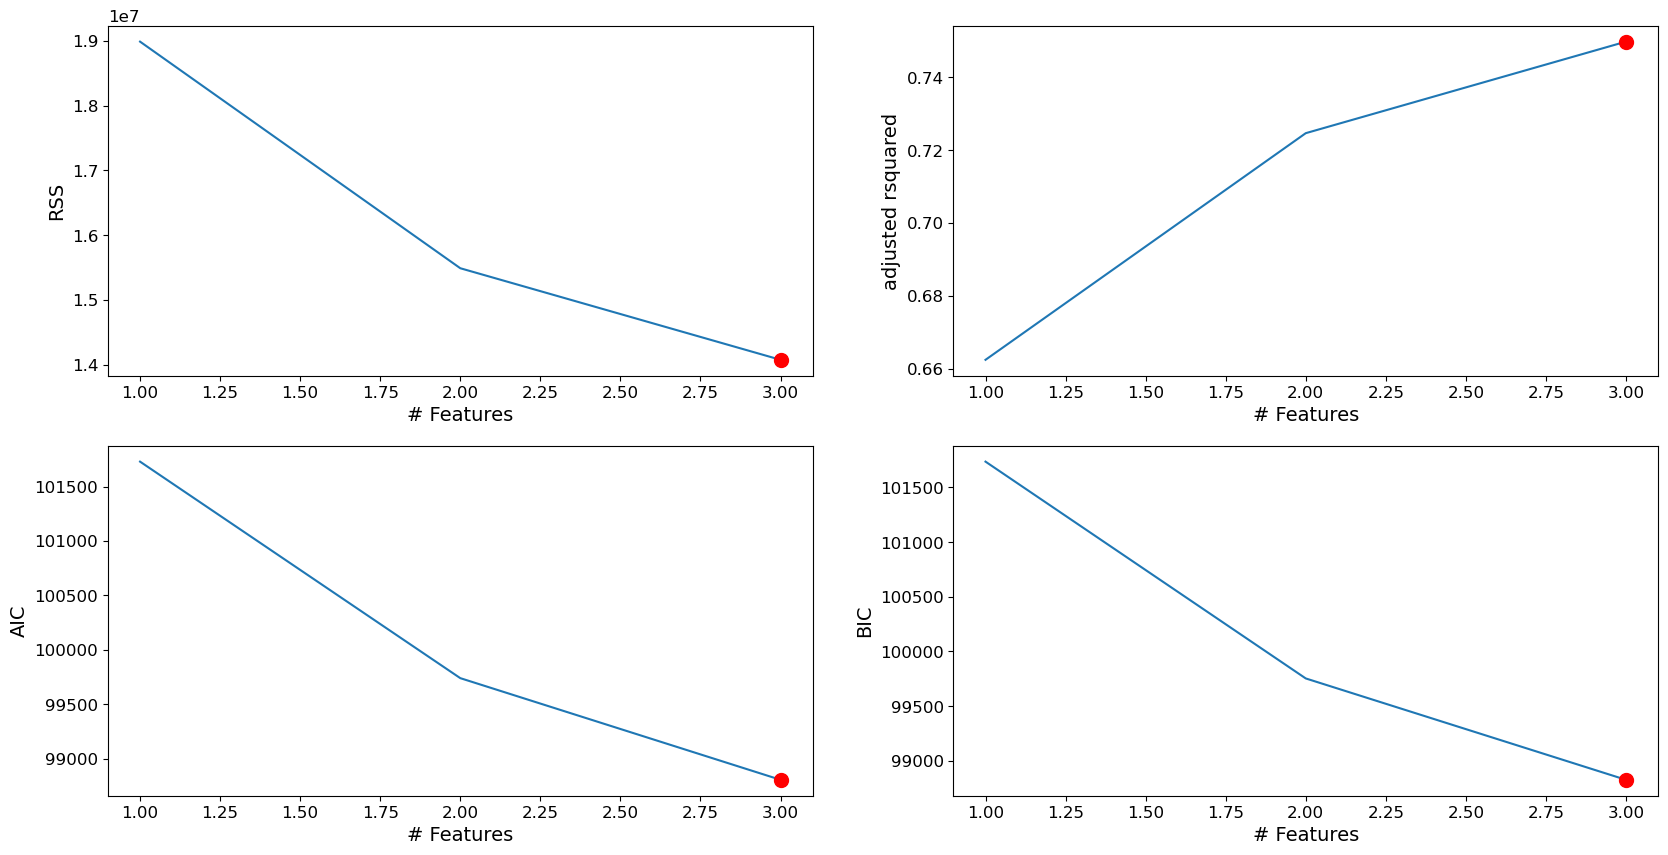

In [20]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the lowest RSS value.
# The argmin() function can be used to identify the location of the minimum point of a vector.
rss = models_best["RSS"]
rss = rss.astype(float)
plt.plot(rss)
plt.plot(rss.argmin()+1, rss.min(), "or")
plt.xlabel('# Features')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector.

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Features')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('BIC')

We see that according to **adjusted-$R^2$**, **AIC**, and **BIC**, the best performer is the model with 3 features. However, no conclusions can be drawn from the reduction of our model to a maximum of 3 features.

## Forward and Backward Stepwise Selection

We can also set up a forward stepwise or backward stepwise selection:

### Forward Selection

In [21]:
def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Running time :

In [22]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
features = []

for i in range(1,len(X_train.columns)+1):    
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  52 models on 1 features in 0.16627979278564453 seconds.
Processed  51 models on 2 features in 0.12207722663879395 seconds.
Processed  50 models on 3 features in 0.23730206489562988 seconds.
Processed  49 models on 4 features in 0.19544291496276855 seconds.
Processed  48 models on 5 features in 0.1518542766571045 seconds.
Processed  47 models on 6 features in 0.15879487991333008 seconds.
Processed  46 models on 7 features in 0.17912983894348145 seconds.
Processed  45 models on 8 features in 0.18703889846801758 seconds.
Processed  44 models on 9 features in 0.20016002655029297 seconds.
Processed  43 models on 10 features in 0.1907179355621338 seconds.
Processed  42 models on 11 features in 0.21941804885864258 seconds.
Processed  41 models on 12 features in 0.22655510902404785 seconds.
Processed  40 models on 13 features in 0.20569205284118652 seconds.
Processed  39 models on 14 features in 0.23011493682861328 seconds.
Processed  38 models on 15 features in 0.22385501861572266 

This method makes it possible to go much faster.

In [23]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.662
Method:                 Least Squares   F-statistic:                          1.918e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:10:16   Log-Likelihood:                         -50863.
No. Observations:                9772   AIC:                                  1.017e+05
Df Residuals:                    9771   BIC:                                  1.017e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

With forward stepwise selection, the best one-feature model contains only the variable `Bedrooms`. For the best two-feature model, we have the variables `Bedrooms` and `Room Type_Entire home/apt`. 

### Backward Selection

In [26]:
def backward(features):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [27]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X_train.columns)))

tic = time.time()
features = X_train.columns

while(len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  52 models on 51 features in 1.3655900955200195 seconds.
Processed  51 models on 50 features in 0.9527838230133057 seconds.
Processed  50 models on 49 features in 0.8955268859863281 seconds.
Processed  49 models on 48 features in 0.984105110168457 seconds.
Processed  48 models on 47 features in 0.9983601570129395 seconds.
Processed  47 models on 46 features in 0.9979770183563232 seconds.
Processed  46 models on 45 features in 0.8160879611968994 seconds.
Processed  45 models on 44 features in 0.8370490074157715 seconds.
Processed  44 models on 43 features in 0.8473432064056396 seconds.
Processed  43 models on 42 features in 0.8243098258972168 seconds.
Processed  42 models on 41 features in 0.7468717098236084 seconds.
Processed  41 models on 40 features in 0.6776061058044434 seconds.
Processed  40 models on 39 features in 0.6224870681762695 seconds.
Processed  39 models on 38 features in 0.612403154373169 seconds.
Processed  38 models on 37 features in 0.5626659393310547 second

For this data, the best 1-feature through 3-feature models are each identical for best subset and backward selection. 
We will only compare between backward stepwise selection and forward stepwise selection, when the identified features change (we cannot compare to the best subset model because for time reasons, our model stops at three features):

In [34]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[3, "model"].params)

------------
Best Subset:
------------
Accomodates                  127.468977
Bathrooms                     79.288894
Room Type_Entire home/apt     26.012463
dtype: float64


In [37]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[11, "model"].params)

-----------------
Foward Selection:
-----------------
Bedrooms                                   54.616082
Room Type_Entire home/apt                  25.079846
Bathrooms                                  83.915373
Accomodates                                74.884845
dist_to_center                            -43.948291
Property Type_Loft                         27.289468
Guests Included                            42.534146
Property Type_Hotel                        90.443688
Property Type_Serviced apartment           43.127653
Host Response Time                         -6.122382
Neighborhood Group_Charlottenburg-Wilm.    13.186426
dtype: float64


In [38]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[11, "model"].params)

-------------------
Backward Selection:
-------------------
Host Response Time                         -6.122382
Accomodates                                74.884845
Bathrooms                                  83.915373
Bedrooms                                   54.616082
Guests Included                            42.534146
Property Type_Hotel                        90.443688
Property Type_Loft                         27.289468
Property Type_Serviced apartment           43.127653
Room Type_Entire home/apt                  25.079846
Neighborhood Group_Charlottenburg-Wilm.    13.186426
dist_to_center                            -43.948291
dtype: float64


The best 1-feature through 11-feature models are each identical for forward subset and backward selection. However, the best 12-feature models identified by forward step selection and backward step selection are different.

## Choosing among models using Validation Set approach and Cross-Validation

We just saw that it is possible to choose among a set of models of different sizes using **AIC**, **BIC**, and **adjusted-$R^2
$**. We will now consider how to do this using the validation set and cross-validation approaches.

We use only the training observations to perform all aspects of model fitting, including variable selection, and thus determine the best model. We have already divided our dataset into a train/validation/test set.

### Declaration variables

In [39]:
train = data_train_df
validation = data_validation_df
test = data_test_df

In [40]:
## For train set
# Extract the target variable
y_train = data_train_df.Price

# Drop the column with the target variable ('Price')
X_train = data_train_df.drop(['Price'], axis=1)

# Define the feature set X_train, our matrix data
X_train.shape

## For validation set
# Extract the target variable
y_validation = data_validation_df.Price

# Drop the column with the target variable ('Price')
X_validation = data_validation_df.drop(['Price'], axis=1)

# Define the feature set X_validation, our matrix data
X_validation.shape

## For test set
# Extract the target variable
y_test = data_test_df.Price

# Drop the column with the target variable ('Price')
X_test = data_test_df.drop(['Price'], axis=1)

# Define the feature set X_test, our matrix data
X_test.shape

## Concatenation for the full dataset
X = pd.concat([X_train,X_validation])
y = pd.concat([y_train,y_validation])

### Model selection using Validation Set approach

We'll define our helper function to outputs the best set of features for each model size like we did in previous part of the lab. Note that we'll need to modify this to take in both validation and training sets, because we want the returned error to be the **validation error** :

In [41]:
def processSubset(feature_set, X_train, y_train, X_validation, y_validation):
    # Fit OLS model on feature_set (from train)
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    # Compute RSS using model predictions on feature_set (from validation set) and the true validation test value of the target
    RSS = ((regr.predict(X_validation[list(feature_set)]) - y_validation) ** 2).sum()
    return {"model":regr, "RSS":RSS}

Our update function to perform forward selection in the context of validation set approach:

In [42]:
def forwardCV(features, X_train, y_train, X_validation, y_validation):
    
    results = []

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    for d in remaining_features:
        results.append(processSubset(features+[d], X_train, y_train, X_validation, y_validation))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

Now, we'll call our `forwardCV()` function on the training set in order to perform forward selection for all model sizes:

In [43]:
models_train = pd.DataFrame(columns=["RSS", "model"])

features = []

for i in range(1,len(X_train.columns)+1):    
    models_train.loc[i] = forwardCV(features, X_train, y_train, X_validation, y_validation)
    features = models_train.loc[i]["model"].model.exog_names

Now let's plot the errors, and find the model that minimizes it:

43


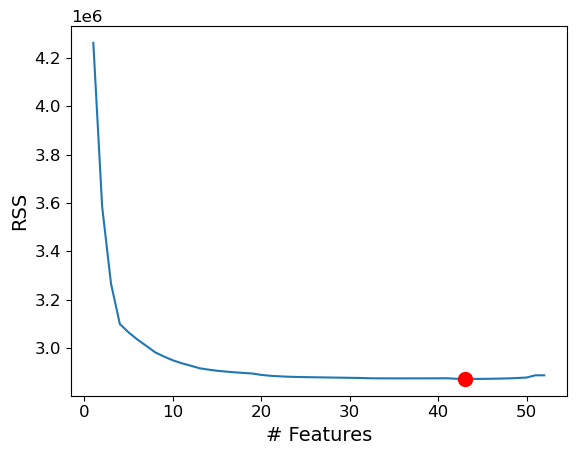

In [44]:
plt.plot(models_train["RSS"])
plt.xlabel('# Features')
plt.ylabel('RSS')
models_train["RSS"] = models_train["RSS"].astype(float)
plt.plot(models_train["RSS"].argmin()+1, models_train["RSS"].min(), "or")
# We use "models_train["RSS"].argmin()+1" because python start counting at zero

#print(models_train["RSS"].argmin())
print(models_train["RSS"].argmin()+1)
#print(models_train["RSS"].min())
#print(models_train["RSS"])

We find that the best model according to the validation set approach is the one that contains 43 features. However, here, we observe that after 11 features the RSS tends to stagnate.

Then, we can perform best subset selection on the full dataset (here train and validation set) and select the best 11-feature model. It is important that we make use of the full data set in order to obtain more accurate coefficient estimates. We perform this selection on the full data set and select the best 11-feature model, rather than simply using the features that we obtained from the training set, because the best 11-feature model on the full data set may differ from the corresponding model on the training set.

In [45]:
## For validation set
models_validation = pd.DataFrame(columns=["RSS", "model"])

features = []

for i in range(1,12):    
    models_validation.loc[i] = forwardCV(features, X_validation, y_validation, X_validation, y_validation)
    features = models_validation.loc[i]["model"].model.exog_names



## For test set
#models_test = pd.DataFrame(columns=["RSS", "model"])

#features = []

#for i in range(1,12):    
    #models_test.loc[i] = forwardCV(features, X[test], y[test], X[test], y[test])
    #features = models_test.loc[i]["model"].model.exog_names

### Model selection using Cross-Validation approach

Now let's try to choose among the models of different sizes using cross-validation. This approach is somewhat involved, as we must perform forward selection within each of the `K` training sets. First, we create a vector that assigns each observation to one of `K`=10 folds, and we create a `DataFrame` in which we will store the results:

In [46]:
# Number of folds
K = 10
np.random.seed(seed=1)
folds = np.random.choice(K, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,K+1), index=range(1,53))
cv_errors = cv_errors.fillna(0)

Now let's write a for loop that performs cross-validation. In the  `K`th fold, the elements of folds that equal `K` are in the validation set, and the remainder are in the training set. We make our predictions for each model size, compute the validation errors on the appropriate subset, and store them in the appropriate slot in the matrix `cv_errors`.

In [47]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for k in range(1,K+1):

    # Reset features
    features = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the kth fold, validation on kth fold
        models_cv.loc[i] = forwardCV(features, X[folds != (k-1)], y[folds != (k-1)], X[folds == (k-1)], y[folds == (k-1)])
        
        # Save the cross-validated error for this fold
        cv_errors[k][i] = models_cv.loc[i]["RSS"]

        # Extract the features
        features = models_cv.loc[i]["model"].model.exog_names

/var/folders/3z/cz7rjl057wg_42pr21gjw_140000gn/T/ipykernel_38981/1001303376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[k][i] = models_cv.loc[i]["RSS"]
/var/folders/3z/cz7rjl057wg_42pr21gjw_140000gn/T/ipykernel_38981/1001303376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[k][i] = models_cv.loc[i]["RSS"]
/var/folders/3z/cz7rjl057wg_42pr21gjw_140000gn/T/ipykernel_38981/1001303376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [48]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,1.727716e+06,2.559233e+06,2.274747e+06,2.596514e+06,2.952021e+06,2.459249e+06,1.709406e+06,1.976389e+06,2.747266e+06,2.061092e+06
2,1.316437e+06,2.134576e+06,1.908823e+06,2.212162e+06,2.365751e+06,2.013153e+06,1.315399e+06,1.626182e+06,2.351539e+06,1.708700e+06
3,1.194187e+06,2.039691e+06,1.773198e+06,2.044231e+06,2.268917e+06,1.846770e+06,1.170239e+06,1.530911e+06,2.196391e+06,1.543574e+06
4,1.119999e+06,1.957598e+06,1.703318e+06,1.963731e+06,2.230860e+06,1.792991e+06,1.084773e+06,1.450532e+06,2.153636e+06,1.479919e+06
5,1.103295e+06,1.903567e+06,1.661388e+06,1.912398e+06,2.212320e+06,1.765270e+06,1.041203e+06,1.417861e+06,2.109926e+06,1.446007e+06
6,1.094858e+06,1.863507e+06,1.638096e+06,1.890905e+06,2.188412e+06,1.750866e+06,1.001976e+06,1.386697e+06,2.068144e+06,1.417167e+06
7,1.086478e+06,1.847855e+06,1.618568e+06,1.870729e+06,2.173542e+06,1.732997e+06,9.765978e+05,1.369146e+06,2.036143e+06,1.389176e+06
8,1.078942e+06,1.830786e+06,1.601937e+06,1.852043e+06,2.166188e+06,1.723351e+06,9.674340e+05,1.355163e+06,2.008474e+06,1.368384e+06
9,1.071751e+06,1.822355e+06,1.586513e+06,1.837144e+06,2.161156e+06,1.709246e+06,9.603417e+05,1.343373e+06,1.982761e+06,1.349820e+06
10,1.061757e+06,1.816403e+06,1.577005e+06,1.823501e+06,2.157365e+06,1.698319e+06,9.531813e+05,1.335628e+06,1.961539e+06,1.341389e+06


This has filled up the `cv_errors` Dataframe such that the $(i,k)^{th}$ element corresponds to the test `MSE` for the $k$th cross-validation fold for the best $i$-feature model. We can then use the `apply()` function to take the mean over the columns of this matrix. This will give us a vector for which the $i$th element is the cross-validation error for the $i$-variable model.

1     2.306363e+06
2     1.895272e+06
3     1.760811e+06
4     1.693736e+06
5     1.657324e+06
6     1.630063e+06
7     1.610123e+06
8     1.595270e+06
9     1.582446e+06
10    1.572609e+06
11    1.566603e+06
12    1.561952e+06
13    1.558327e+06
14    1.555589e+06
15    1.553555e+06
16    1.552179e+06
17    1.551124e+06
18    1.550103e+06
19    1.548960e+06
20    1.548288e+06
21    1.547329e+06
22    1.546280e+06
23    1.544639e+06
24    1.544077e+06
25    1.543653e+06
26    1.543322e+06
27    1.542979e+06
28    1.542758e+06
29    1.542687e+06
30    1.542711e+06
31    1.542825e+06
32    1.543008e+06
33    1.543185e+06
34    1.543257e+06
35    1.543402e+06
36    1.543677e+06
37    1.544016e+06
38    1.543993e+06
39    1.544296e+06
40    1.544569e+06
41    1.545184e+06
42    1.546010e+06
43    1.547029e+06
44    1.547996e+06
45    1.549072e+06
46    1.550808e+06
47    1.552590e+06
48    1.554466e+06
49    1.557942e+06
50    1.561046e+06
51    1.571310e+06
52    1.571310e+06
dtype: float

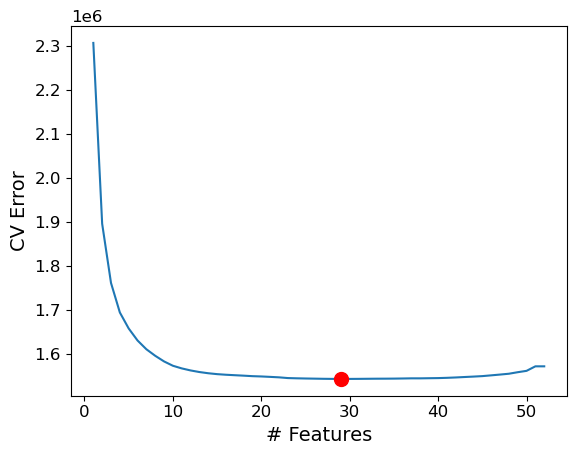

In [49]:
cv_mean = cv_errors.apply(np.mean, axis=1)
print(cv_mean)

plt.plot(cv_mean)
plt.xlabel('# Features')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

We see that cross-validation selects a 29-feature model. However, to continue, we will choose the value of 11 features (after this value the error tends to stagnate). Now let's go back to our results on the full data set in order to obtain the 11-feature model.

In [50]:
print(models_cv.loc[11, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.768
Model:                            OLS   Adj. R-squared (uncentered):              0.768
Method:                 Least Squares   F-statistic:                              3307.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:18:20   Log-Likelihood:                         -55128.
No. Observations:               10993   AIC:                                  1.103e+05
Df Residuals:                   10982   BIC:                                  1.104e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------

# Dimension Reduction Methods

##  Principal Components Analysis (PCA)

Principal Components Analysis (PCA) is a popular approach for deriving a low-dimensional set of features from a large set of features. This reduction dimension method can be performed using the PCA() function, which is part of the sklearn library. 

### Set up !

In [51]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
import mpl_toolkits.mplot3d 

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go

### PCA

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data. As our data has already been scaled, we took our unscaled data in order to perform PCA.

In [54]:
## Download train dataset
# Extract the target variable
y_train = data_train_df.Price

# Drop the column with the target variable ('Price')
X_train = data_train_df.drop(['Price'], axis=1)


## Download validation dataset
# Extract the target variable
y_validation = data_validation_df.Price

# Drop the column with the target variable ('Price')
X_validation = data_validation_df.drop(['Price'], axis=1)


## Download test dataset
# Extract the target variable
y_test = data_test_df.Price

# Drop the column with the target variable ('Price')
X_test = data_test_df.drop(['Price'], axis=1)

Now let's perform PCA on the training data and evaluate its validation set performance. This process is also helpful to tune the hyper-parameter $M$ and identify the number of components to use. We'll perform 10-fold cross-validation to see how it influences the `MSE`:

[2168.943836600494, 1739.3503137171406, 1707.962311048555, 1706.1154115954753, 1706.5037054880067, 1702.3138768427348, 1700.0458378173287, 1699.2438649322696, 1699.09346658179, 1691.4925371109778, 1678.9614774494173, 1678.8214635466124, 1670.155207997585, 1670.4875923646098, 1670.737225699831, 1513.8120748500428, 1388.7699157377237, 1380.0019311847223, 1377.4228956095055, 1370.6560561201363, 1370.908544403834, 1365.155409776219, 1366.0279383559373, 1361.8979322758582, 1355.4439954010127, 1355.9633824539246, 1339.3955678930708, 1338.4778383978105, 1334.123957911302, 1334.5097789482224, 1333.112455251096, 1330.6652123493918, 1332.4786362141506, 1332.2879400311967, 1332.6339718013098, 1332.1530516565217, 1332.4519786128474, 1332.4950994322414, 1332.9836996580075, 1332.6404199599451, 1327.1754177457235, 1327.183633146973, 1327.9300694391893, 1324.4281572051525, 1316.348503051207, 1316.439807056535, 1316.0754196923094, 1313.7497682166506, 1313.8151261420794, 1314.2928022620117, 1316.7718951

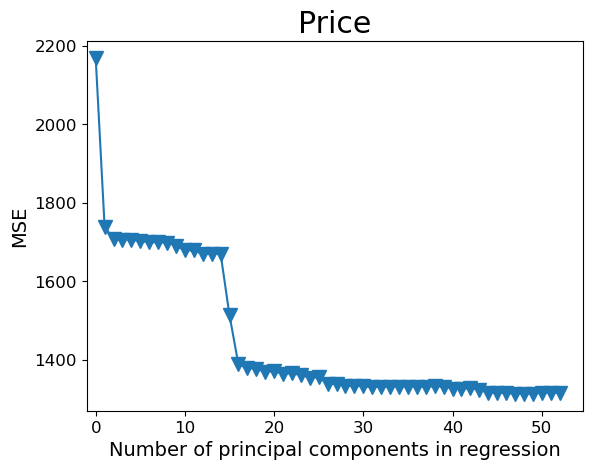

In [55]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train)

n = len(X_train_reduced)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

regr = LinearRegression()

# Compute MSE with only the intercept (no principal components in regression)
#and 10-fold CV is only applied on the validation set
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)
#print(mse)

# Compute MSE using CV for the 53 principal components, adding one component at the time
#10-fold CV is only applied on the train set
for i in np.arange(1, 53):
    score = -1*model_selection.cross_val_score(regr, X_train_reduced[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1);

print(mse)

We see that the smallest cross-validation error occurs when $M=48$ components are used. However, from the plot we also see that the cross-validation error is roughly the same when only 17 components are included in the model. This suggests again that a model that uses just a small number of components might suffice. 

We'll print the amount of variance explained by adding each consecutive principal component:

In [56]:
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)

[ 20.    31.54  40.6   49.03  56.74  63.79  70.1   74.35  78.39  81.99
  84.73  86.46  87.96  89.39  90.6   91.75  92.66  93.54  94.28  94.94
  95.51  95.88  96.25  96.56  96.84  97.11  97.36  97.59  97.81  98.03
  98.24  98.45  98.61  98.76  98.89  99.01  99.13  99.24  99.35  99.45
  99.55  99.65  99.73  99.8   99.86  99.91  99.96  99.99 100.01 100.01
 100.01 100.01]


Setting $M=1$ only captures 20% of all the variance, or information, in the features. In contrast, using $M=11$ increases the value to 84.73%. 

Now, we fix the hyper-parameter  $M$  to 11, and we'll see how it performs on the validation data and compute the validation MSE as follows: 

In [57]:
## For validation set
X_validation_reduced = pca.fit_transform(X_validation)[:,:11]

#print(X_validation_reduced.shape)
#pd.DataFrame(X_validation_reduced).info()

# If you want to compare before and after to apply the PCA:
#print(pd.DataFrame(X_validation_reduced).describe())
#print(pd.DataFrame(X_validation).describe())

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_train_reduced[:,:11], y_train)

# Prediction with validation data
pred = regr.predict(X_validation_reduced)
print('The final test MSE is: ',mean_squared_error(y_validation, pred))



## For test set
#X_test_reduced = pca.fit_transform(X_test)[:,:11]

#regr = LinearRegression()
#regr.fit(X_train_reduced[:,:11], y_train)

#pred = regr.predict(X_test_reduced)
#print('The final test MSE is: ',mean_squared_error(y_test, pred))

The final test MSE is:  1618.3035420899541


## PCA visualization for $M=11$ components on data_airbnb dataset

This part is intended to more visualize PCA using python. We continue to work on the `data_airbnb` dataset that has 52 features which we can reduce to $M=11$ (as suggested by the previous part of this lab) by using PCA.

In PCA(), `n_component` specifies how many components are returned after fit and tranformation.

In [59]:
## For validation set
pcamodel = PCA(n_components=11)
pca = pcamodel.fit_transform(X_validation)
pca.shape

## For test set
#pcamodel = PCA(n_components=11)
#pca = pcamodel.fit_transform(X_test)
#pca.shape

(2443, 11)

PCA components and their significance can be explained using `explained_variance_ratio_` that is the percentage of variance explained by each of the selected components.

In [60]:
#the percentage of variance explained by each of the selected components
pcamodel.explained_variance_ratio_

array([0.20106469, 0.11392844, 0.0884734 , 0.08364973, 0.07760006,
       0.07087666, 0.06130837, 0.04211067, 0.03995389, 0.03515737,
       0.02715749])

Some PCA model attribute plots can help for visualization:

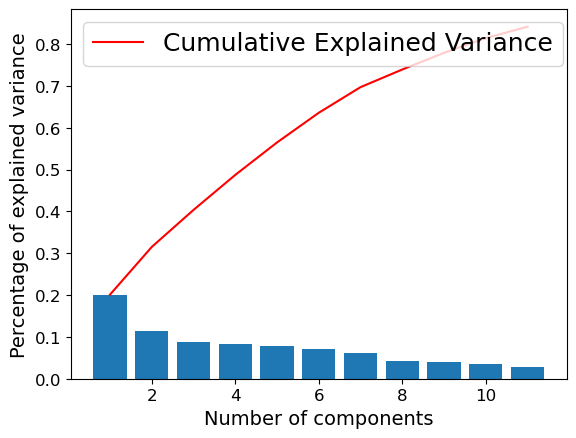

In [61]:
# Explained variance plot
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')


Scree plot is the plot of eigen values (explained_variance_) for each of the components.

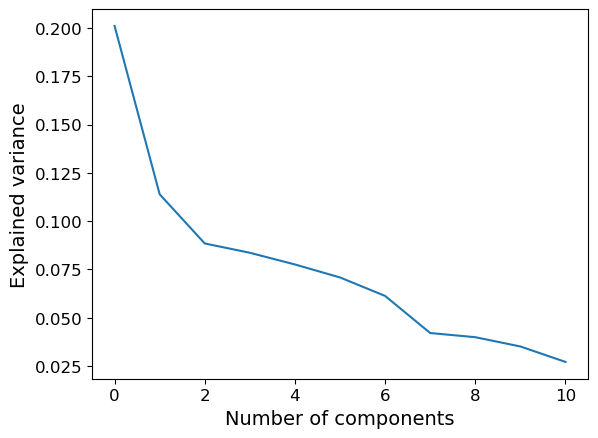

In [62]:
# Scree plot
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

It can be seen from plots that, eleven first components explains most of the variance than subsequent components. Here, most of the features are explained and encompassed by the eleven first components. 

# Conclusion and dimensionality reduction to 11 features

We observe, from forward and backward selection and also by PCA that the group of 8 features : `Accomodates`, `Bathrooms`, `Bedrooms`, `Guests Included`, `Property Type_Loft`, `Property Type_Hotel`, `Property Type_Serviced apartement`, `Room Type_Entire home/apt`, `Host Response Time`, `Neighborhood Group_Charlottenburg-Wilm.` and `dist-to-center`, explains most of the variance. We will now reduce our full dataset to those 8 features.

Let's run the cleaned and scaled files obtained in data_cleaning.py (data_train_df, data_validation_df and data_test_df) to obtain reduced CSVs of these files:

In [63]:
import pandas as pd
import numpy as np
import os

class ReductionDim:
    columns_to_keep = [
          'Accomodates',
          'Bathrooms',
          'Bedrooms',
          'Guests Included',
          'Property Type_Apartment',
          'Property Type_Hotel',
          'Room Type_Entire home/apt',
          'dist_to_center',
    ]

    def __init__(self, path: str) -> None:
            self.path = path
            self.df = None

    def df_creation(self):
            """ Loading the DataFrame."""
            self.df = pd.read_csv(self.path)
            # Dropping columns
            self.df = self.df[ReductionDim.columns_to_keep + ['Price']]

    def save_csv(self, df: pd.DataFrame, csv_name:str):
        """ Saves the cleaned dataframe in a csv file in the same folder as the
            one containing the cleaned dataframe.
            Attribute:
                - csv_name : name of the csv file created """
        df.to_csv(os.path.join(self.path.rsplit("/", 1)[0], csv_name), index=False)

    def data_reducdim(self) -> pd.DataFrame:
        """ Main method: applies all the preprocesses. """
        self.df_creation()
        self.save_csv(self.df, csv_name="data_train_reduced.csv")
        self.save_csv(self.df, csv_name="data_val_reduced.csv")
        self.save_csv(self.df, csv_name="data_test_reduced.csv")

data_train_path = "/Users/albane/Desktop/ML/ml-project/data/data_train.csv"
data_val_path = "/Users/albane/Desktop/ML/ml-project/data/data_val.csv"
data_test_path = "/Users/albane/Desktop/ML/ml-project/data/data_test.csv"

data_reducer = ReductionDim(path=data_train_path)
data_reducer.data_reducdim()
data_reducer = ReductionDim(path=data_val_path)
data_reducer.data_reducdim()
data_reducer = ReductionDim(path=data_test_path)
data_reducer.data_reducdim()